In [35]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
import pandas as pd
import scipy

In [82]:
# If Surface fluxes are available
SF = False

In [83]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
Cp=4000
rho=1024
S0=35

## ERA5 begins in 1979 so we have to change our "early" and "late" periods
dyrs = 9
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12
range_yrs = init_late-init_early+1

In [84]:
%%time
ERA5_BSP_data = xr.open_mfdataset('BSP_processed/BSP_ERA5_TS_*.nc')

## Early Period
Part_early = ERA5_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ERA5_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ERA5_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
V_early = ERA5_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ERA5_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
Asection_early = ERA5_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ERA5_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ERA5_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ERA5_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = ERA5_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ERA5_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
Asection_late = ERA5_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ERA5_BSP_data.Basin.values
Sections = ERA5_BSP_data.Section.values


CPU times: user 554 ms, sys: 161 ms, total: 714 ms
Wall time: 1 s


In [85]:
# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()
AS_1 = Asection_early.values.flatten()
AS_2 = Asection_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [86]:
## Load ERA5 data here, if provided
if SF:
    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum = ERA5_BSP_data.hfds_sum.cumsum('Time').isel(Time=-1)*(1/(24*3600))*(yr2sec/12) # units: J
    WFO_cumsum = ERA5_BSP_data.wfo_sum.cumsum('Time').isel(Time=-1)*yr2sec/12 # units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs))
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs))

    ## Convert dflux to equivalent T or S change

    dT_hfds = dhfds/(Cp*rho*V_early) # units: C
    dS_wfo = -dwfo*S0/(rho*V_early) # units: g/kg

    time = ERA5_BSP_data.Time.values
    
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0

In [87]:
if SF:
    Opt_result = xr.open_mfdataset('Optimisation_results/Optimal_result_EN4_SF_79_06.nc')
    RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')
else:
    Opt_result = xr.open_mfdataset('Optimisation_results/Optimal_result_EN4_freerun.nc')
    RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')

mean_MOC_RAPID = RAPID_example.moc_mar_hc10.mean('time').values

OSError: no files to open

In [ ]:
# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
d_ij = np.zeros((Basins.size,Basins.size))

d_ij[0,:] = [1, -1, 0, 0, 0, 0, 0, 0, 0]
d_ij[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
d_ij[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
d_ij[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
d_ij[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
d_ij[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
d_ij[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
d_ij[7,:] = [0, 0, 0, 0, 0, 0, -1, 1, 0]
d_ij[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: d_ij.T[0,:],\
    Basins[1]: d_ij.T[1,:],\
    Basins[2]: d_ij.T[2,:],\
    Basins[3]: d_ij.T[3,:],\
    Basins[4]: d_ij.T[4,:],\
    Basins[5]: d_ij.T[5,:],\
    Basins[6]: d_ij.T[6,:],\
    Basins[7]: d_ij.T[7,:],\
    Basins[8]: d_ij.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table


,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0,1.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [ ]:
g_ij = Opt_result.gij.values

section_trans = np.zeros((Vol_1.size,Vol_1.size))
for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]/(range_yrs*yr2sec*10**6)*d_ij[int(Basin_1_inds[i]), int(Basin_2_inds[j])]

int_section_trans = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[128*i:(128*(i+1)),128*j:(128*(j+1))])

section_trans_temp = np.zeros((Vol_1.size, Basins.size))
for j in range(Basins.size):
    section_trans_temp[:,j] = np.nansum(section_trans[:,128*j:(128*(j+1))],axis=-1)

In [ ]:
basin_connex = np.array([[0,1],
                [1,2],
                [2,3],
                [3,8],
                [4,8],
                [4,6],
                [5,8],
                [6,5],
                [7,6]]).astype(int)

T_joined = np.zeros((int(np.size(basin_connex)/2), 256))
section_joined = np.zeros((int(np.size(basin_connex)/2), 256))

for i in range(int(np.size(basin_connex)/2)):
    T_joined[i,:] = np.concatenate([T_1[128*basin_connex[i][0]:(128*(basin_connex[i][0]+1))],T_1[128*basin_connex[i][1]:(128*(basin_connex[i][1]+1))]])
    section_joined[i,:] = np.concatenate([section_trans_temp[128*basin_connex[i][0]:(128*(basin_connex[i][0]+1)),basin_connex[i][1]],\
        section_trans_temp[128*basin_connex[i][1]:(128*(basin_connex[i][1]+1)),basin_connex[i][0]]])

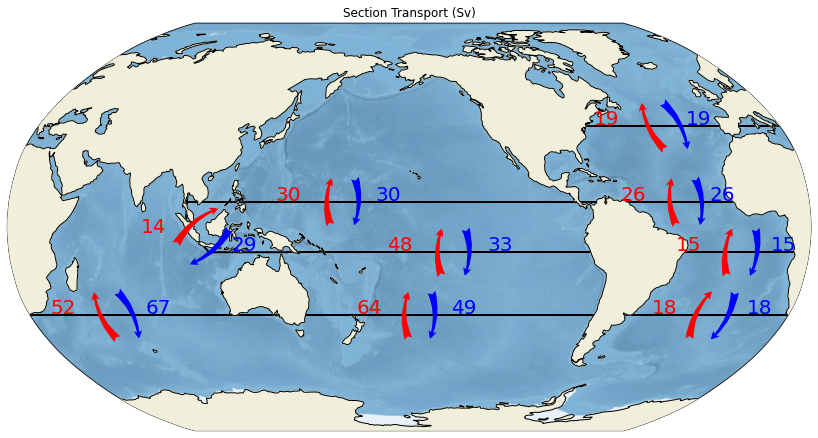

In [ ]:
fig  = plt.figure(1, figsize = (17.5, 7.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.add_feature(cfeature.LAND, zorder=100)

## S PAC <> SO

ax1.annotate('', xy=(200,-25), xytext=(200, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[5,-1])), xy=(200,-25), xytext=(220, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(210,-45), xytext=(210, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,5]), xy=(175,-25), xytext=(175, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> S PAC

ax1.annotate('', xy=(215,0), xytext=(215, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,5])), xy=(235,-9.5), xytext=(235, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(225,-20), xytext=(225, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[5,6]), xy=(190,-9.5), xytext=(190, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> N PAC

ax1.annotate('', xy=(165,20), xytext=(165, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[7,6])), xy=(185,10.5), xytext=(185, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(175,0), xytext=(175, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,7])), xy=(140,10.5), xytext=(140, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## IND <> SO

ax1.annotate('', xy=(55,-25), xytext=(55, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(int_section_trans[4,-1])), xy=(75,-25), xytext=(75, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(65,-45), xytext=(65, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,4]), xy=(30,-25), xytext=(30, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> IND

ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,4])), xy=(75,-9.5), xytext=(120, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(100, -15), xytext=(120,0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[4,6]), xy=(80,-2.5), xytext=(80, -2.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)


## S ATL <> SO

ax1.annotate('', xy=(340,-25), xytext=(340, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[3,-1])), xy=(360,-25), xytext=(360, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(350,-45), xytext=(350, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,3]), xy=(315,-25), xytext=(315, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ ATL <> S ATL

ax1.annotate('', xy=(345,0), xytext=(345, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[2,3])), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(355,-20), xytext=(355, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[3,2]), xy=(320,-9.5), xytext=(320, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ ATL <> ST ATL

ax1.annotate('', xy=(320,20), xytext=(320, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[1,2])), xy=(335,10.5), xytext=(335, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(330,0), xytext=(330, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[2,1])), xy=(295,10.5), xytext=(295, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## ST ATL <> POL ATL

ax1.annotate('', xy=(320,50), xytext=(320, 30),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(int_section_trans[0,1])), xy=(335,40.5), xytext=(335, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(330,30), xytext=(330, 50),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[1,0])), xy=(290,40.5), xytext=(290, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

plt.title('Section Transport (Sv)')
if SF:
    plt.savefig('Figures/Land_mask_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/Land_mask_freerun.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
section_names = np.array([r'40$^{\circ}$N (Atlantic)', 
                r'10$^{\circ}$N (Atlantic)',
                r'10$^{\circ}$S (Atlantic)', 
                r'35$^{\circ}$S (Atlantic)',
                r'35$^{\circ}$S (Indian)',
                r'110 - 100 $^{\circ}$E, 10 - 0 $^{\circ}$S (ITF)',
                r'35$^{\circ}$S (Pacific)',
                r'10$^{\circ}$S (Pacific)',
                r'10$^{\circ}$N (Pacific)'])

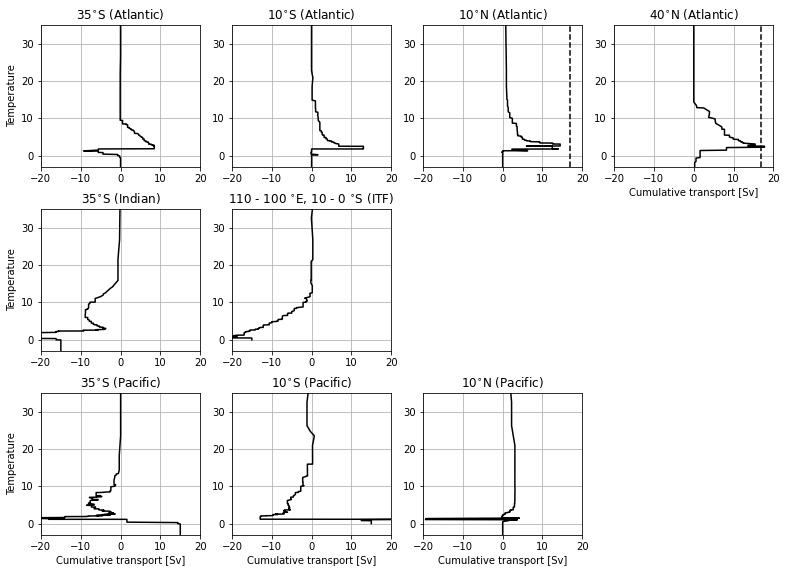

In [ ]:
fig  = plt.figure(1, figsize = (17.5*0.75, 12.5*0.75))
gs = gridspec.GridSpec(3,4)
gs.update(wspace = 0.2, hspace=0.3)

ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), \
           plt.subplot(gs[0,1]), \
           plt.subplot(gs[0,2]) , \
           plt.subplot(gs[0,3])

ax5, ax6 = plt.subplot(gs[1,0]), \
           plt.subplot(gs[1,1])

ax7, ax8,ax9 = plt.subplot(gs[2,0]), \
           plt.subplot(gs[2,1]), \
            plt.subplot(gs[2,2])

ax1.plot(np.nancumsum(section_joined[3,:][np.argsort(T_joined[3,:])][::-1])[::-1], T_joined[3,:][np.argsort(T_joined[3,:])], '-k')
ax1.set_title(section_names[3])
ax1.set_ylim(-3,35)
ax1.set_xlim(-20,20)

ax2.plot(np.nancumsum(section_joined[2,:][np.argsort(T_joined[2,:])][::-1])[::-1], T_joined[2,:][np.argsort(T_joined[2,:])], '-k')
ax2.set_title(section_names[2])
ax2.set_ylim(-3,35)
ax2.set_xlim(-20,20)

ax3.plot(np.nancumsum(section_joined[1,:][np.argsort(T_joined[1,:])][::-1])[::-1], T_joined[1,:][np.argsort(T_joined[1,:])], '-k')
ax3.vlines(mean_MOC_RAPID, -3,35, color='black', linestyle='dashed')
ax3.set_title(section_names[1])
ax3.set_ylim(-3,35)
ax3.set_xlim(-20,20)

ax4.plot(np.nancumsum(section_joined[0,:][np.argsort(T_joined[0,:])][::-1])[::-1], T_joined[0,:][np.argsort(T_joined[0,:])], '-k')
ax4.vlines(mean_MOC_RAPID, -3,35, color='black', linestyle='dashed')
ax4.set_title(section_names[0])
ax4.set_ylim(-3,35)
ax4.set_xlim(-20,20)
ax4.set_xlabel('Cumulative transport [Sv]')

ax5.plot(np.nancumsum(section_joined[4,:][np.argsort(T_joined[4,:])][::-1])[::-1], T_joined[4,:][np.argsort(T_joined[4,:])], '-k')
ax5.set_title(section_names[4])
ax5.set_ylim(-3,35)
ax5.set_xlim(-20,20)

ax6.plot(np.nancumsum(section_joined[5,:][np.argsort(T_joined[5,:])][::-1])[::-1], T_joined[5,:][np.argsort(T_joined[5,:])], '-k')
ax6.set_title(section_names[5])
ax6.set_ylim(-3,35)
ax6.set_xlim(-20,20)

ax7.plot(np.nancumsum(section_joined[6,:][np.argsort(T_joined[6,:])][::-1])[::-1], T_joined[6,:][np.argsort(T_joined[6,:])], '-k')
ax7.set_title(section_names[6])
ax7.set_ylim(-3,35)
ax7.set_xlim(-20,20)
ax7.set_xlabel('Cumulative transport [Sv]')

ax8.plot(np.nancumsum(section_joined[7,:][np.argsort(T_joined[7,:])][::-1])[::-1], T_joined[7,:][np.argsort(T_joined[7,:])], '-k')
ax8.set_title(section_names[7])
ax8.set_ylim(-3,35)
ax8.set_xlim(-20,20)
ax8.set_xlabel('Cumulative transport [Sv]')

ax9.plot(np.nancumsum(section_joined[8,:][np.argsort(T_joined[8,:])][::-1])[::-1], T_joined[8,:][np.argsort(T_joined[8,:])], '-k')
ax9.set_title(section_names[8])
ax9.set_ylim(-3,35)
ax9.set_xlim(-20,20)
ax9.set_xlabel('Cumulative transport [Sv]')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()
ax9.grid()

ax1.set_ylabel('Temperature')
ax5.set_ylabel('Temperature')
ax7.set_ylabel('Temperature')

if SF:
    plt.savefig('Figures/Section_transports_Temp_space_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/Section_transports_Temp_space_freerun.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
## Interpolate transports onto same T grid

T_grid = np.linspace(-1,32,300)
transports_interped = np.zeros((section_names.size, T_grid.size))
for i in range(section_names.size):
    f_interp = scipy.interpolate.interp1d(T_joined[i,:][np.argsort(T_joined[i,:])], \
        np.nancumsum(section_joined[i,:][np.argsort(T_joined[i,:])][::-1])[::-1], \
            fill_value=(np.nancumsum(section_joined[i,:][np.argsort(T_joined[i,:])][::-1])[::-1][0],\
                np.nancumsum(section_joined[i,:][np.argsort(T_joined[i,:])][::-1])[::-1][-1]),\
                    bounds_error=False)

    transports_interped[i,:] = f_interp(T_grid)

In [ ]:
Atl_lats = np.array([-90,-35,-10,10,40,90])
Pac_lats = np.array([-90,-35,-10,10,90])

Pac_overturning = np.array([np.zeros_like(T_grid), 
(transports_interped[4,:])\
+(transports_interped[6,:]),
(transports_interped[5,:])+\
(transports_interped[7,:]),
(transports_interped[8,:]),
np.zeros_like(T_grid)])

Atl_overturning = np.array([np.zeros_like(T_grid), (transports_interped[3,:]),
(transports_interped[2,:]),
(transports_interped[1,:]),
(transports_interped[0,:]),
np.zeros_like(T_grid)])

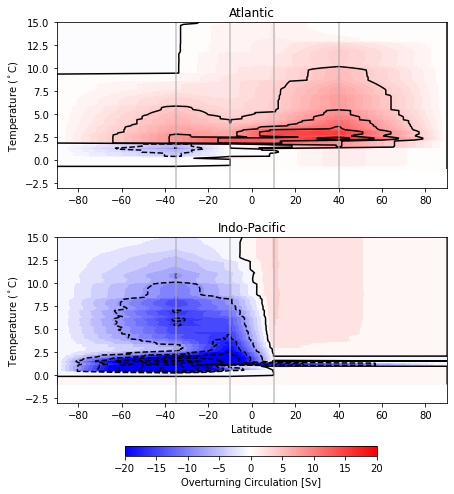

In [ ]:

fig  = plt.figure(1, figsize = (17.5*0.4, 17.5*0.4))
gs = gridspec.GridSpec(2,2)
gs.update(wspace = 0.2, hspace=0.3)

ax1, ax2 = plt.subplot(gs[0,:]), \
           plt.subplot(gs[1,:])

ax1.contourf(Atl_lats, T_grid, np.moveaxis(Atl_overturning,0,-1), 50,vmin=-20, vmax=20, cmap=plt.cm.bwr)
ax1.contour(Atl_lats, T_grid, np.moveaxis(Atl_overturning,0,-1), level=np.linspace(-20,20,8), colors='black', linewidth=0.5)
ax1.vlines(Atl_lats[1:-1],-3,35, color='darkgrey', alpha=0.7)
ax2.contourf(Pac_lats, T_grid, np.moveaxis(Pac_overturning,0,-1), 50,vmin=-20, vmax=20, cmap=plt.cm.bwr)
ax2.contour(Pac_lats, T_grid, np.moveaxis(Pac_overturning,0,-1), level=np.linspace(-20,20,8), colors='black', linewidth=0.5)
ax2.vlines(Pac_lats[1:-1],-3,35, color='darkgrey', alpha=0.7)

# ax1.plot(np.cumsum((temp_binned_transport[3,:])[::-1])[::-1],temp_mid, '-k')
ax1.set_title('Atlantic')
ax2.set_title('Indo-Pacific')
ax1.set_ylim(-3,15)
ax2.set_ylim(-3,15)
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Temperature ($^\circ$C)')

cax = fig.add_axes([0.26, 0.02, 0.5, 0.02])

m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(-20, 20)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('Overturning Circulation [Sv]') 

if SF:
    plt.savefig('Figures/Overturning_EN4_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/Overturning_EN4_freerun.png', bbox_inches='tight', dpi=300)

plt.show()

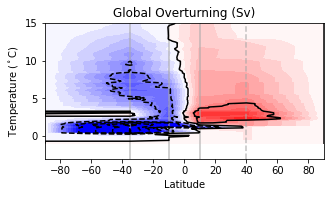

In [ ]:
Glob_overturning = np.zeros_like(Atl_overturning)
for i in range(5):
    if i ==5:
        Glob_overturning[i,:] = Atl_overturning[i,:]
    else:
        Glob_overturning[i,:] = Atl_overturning[i,:]+Pac_overturning[i,:]

plt.figure(figsize=(5,2.5))
plt.contourf(Atl_lats, T_grid, np.moveaxis(Glob_overturning,0,-1), 50,vmin=-20, vmax=20, cmap=plt.cm.bwr)
plt.vlines(Atl_lats[1:-2],-3,35, color='darkgrey', alpha=0.7)
plt.vlines(Atl_lats[-2],-3,35, color='darkgrey', linestyle='dashed', alpha=0.7)
plt.contour(Atl_lats, T_grid, np.moveaxis(Glob_overturning,0,-1), level=np.linspace(-20,20,8), colors='black', linewidth=0.5)

cax = fig.add_axes([0.26, 0.02, 0.5, 0.02])

m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(-20, 20)
cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_label('Overturning Circulation [Sv]') 

plt.ylim(-3,15)

plt.xlabel('Latitude')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('Global Overturning (Sv)')

if SF:
    plt.savefig('Figures/GlobOverturning_EN4_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/GlobOverturning_EN4_freerun.png', bbox_inches='tight', dpi=300)

plt.show()


In [ ]:
heat_trans = T_joined*section_joined*rho*Cp*10**6
HF_section_tot = np.nansum(heat_trans, axis=-1)/10**15
OHU_basins = np.nansum((rho*Cp*Vol_1*(T_2-T_1)).reshape(9,128),axis=-1)/(range_yrs*yr2sec*10**15) # units: PW

In [ ]:
mask_EN4_xr = xr.open_mfdataset('Basin_mask/mask_EN4.nc')
mask_EN4 = (mask_EN4_xr.__xarray_dataarray_variable__.isel(depth=0).values)
OHU_remapped = np.zeros_like(mask_EN4)

for j in range(Basins.size):
    OHU_remapped[j,:,:] = mask_EN4[j,:,:]*OHU_basins[j]

## LOAD T and S data from a gridded observations (e.g., we use EN4 here)
## For the purposes of the tutorial we only select the first 3 months of the data
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_*')

lats = data.lat.values
lons = data.lon.values


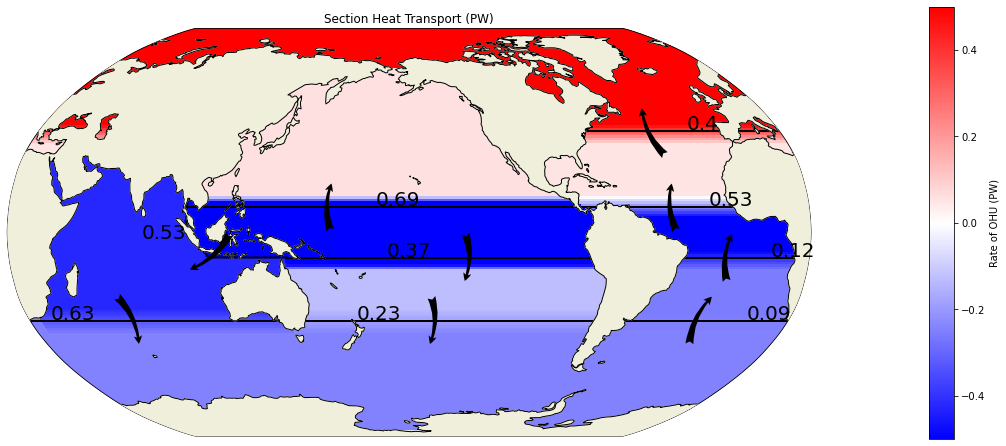

In [ ]:
fig  = plt.figure(1, figsize = (17.5, 7.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.pcolormesh(lons, lats, np.nansum(OHU_remapped,axis=0), transform = ccrs.PlateCarree(), vmin=-0.5, vmax=0.5, cmap=plt.cm.bwr)
ax1.add_feature(cfeature.LAND, zorder=100)
cax = fig.add_axes([0.925, 0.12, 0.02, 0.8])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-0.5, 0.5)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Rate of OHU (PW)')

## S PAC <> SO

if HF_section_tot[6]>0:
        ax1.annotate('', xy=(200,-25), xytext=(200, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[6]).round(2)), xy=(200,-25), xytext=(220, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(210,-45), xytext=(210, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[6]).round(2)), xy=(175,-25), xytext=(175, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ PAC <> S PAC
if HF_section_tot[7]>0:

        ax1.annotate('', xy=(215,0), xytext=(215, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[7]).round(2)), xy=(235,-9.5), xytext=(235, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(225,-20), xytext=(225, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[7]).round(2)), xy=(190,-9.5), xytext=(190, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ PAC <> N PAC
if HF_section_tot[8]>0:


        ax1.annotate('', xy=(165,20), xytext=(165, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[8]).round(2)), xy=(185,10.5), xytext=(185, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(175,0), xytext=(175, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[8]).round(2)), xy=(140,10.5), xytext=(140, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## IND <> SO
if HF_section_tot[4]>0:
        ax1.annotate('', xy=(55,-25), xytext=(55, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((HF_section_tot[4]).round(2)), xy=(75,-25), xytext=(75, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(65,-45), xytext=(65, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[4]).round(2)), xy=(30,-25), xytext=(30, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ PAC <> IND
if HF_section_tot[5]>0:
        ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[5]).round(2)), xy=(75,-9.5), xytext=(120, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(100, -15), xytext=(120,0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[5]).round(2)), xy=(80,-2.5), xytext=(80, -2.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)


## S ATL <> SO
if HF_section_tot[3]>0:

        ax1.annotate('', xy=(340,-25), xytext=(340, -45),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[3]).round(2)), xy=(360,-25), xytext=(360, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(350,-45), xytext=(350, -25),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[3]).round(2)), xy=(315,-25), xytext=(315, -34.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ ATL <> S ATL
if HF_section_tot[2]>0:

        ax1.annotate('', xy=(345,0), xytext=(345, -20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[2]).round(2)), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(355,-20), xytext=(355, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[2]).round(2)), xy=(320,-9.5), xytext=(320, -9.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## EQ ATL <> ST ATL
if HF_section_tot[1]>0:

        ax1.annotate('', xy=(320,20), xytext=(320, 0),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[1]).round(2)), xy=(335,10.5), xytext=(335, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(330,0), xytext=(330, 20),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[1]).round(2)), xy=(295,10.5), xytext=(295, 10.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

## ST ATL <> POL ATL
if HF_section_tot[0]>0:

        ax1.annotate('', xy=(320,50), xytext=(320, 30),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
        ax1.annotate(abs((HF_section_tot[0]).round(2)), xy=(335,40.5), xytext=(335, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)
else:
        ax1.annotate('', xy=(330,30), xytext=(330, 50),
                size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
                arrowprops=dict(facecolor='black', ec='none',
                                arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

        ax1.annotate(abs((HF_section_tot[0]).round(2)), xy=(290,40.5), xytext=(290, 40.5), \
                xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='black', fontsize=20, zorder=103)

ax1.set_title('Section Heat Transport (PW)')

if SF:
    plt.savefig('Figures/Heat_fluxes_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/Heat_fluxes_freerun.png', bbox_inches='tight', dpi=300)
plt.show()

-------------

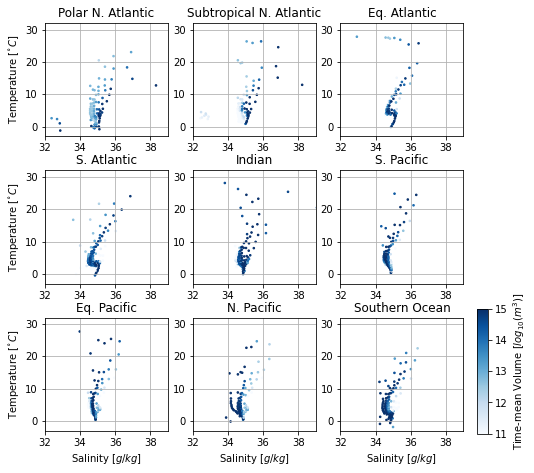

In [88]:
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = 11,15
cmap = 'Blues'

for bx in range(Basins.size):
    axs[bx].scatter(SA_early[bx,:],CT_early[bx,:], 10, np.log10(V_early[bx,:]),cmap=cmap, vmin=minv, vmax=maxv, marker = '.')
    axs[bx].set_xlim(32,39)
    axs[bx].set_ylim(-3,32)
    axs[bx].set_title(Basins[bx])
    if bx==0 or bx==3 or bx==6:
        axs[bx].set_ylabel('Temperature [$^{\circ}C$]')
    if bx==6 or bx==7 or bx==8:
        axs[bx].set_xlabel('Salinity [$g/kg$]')
    axs[bx].grid()
    
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Time-mean Volume [$log_{10}(m^3)$]') 
if SF:
    plt.savefig('Figures/BSP_clustering_mean_volumes_Vbased_SF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/BSP_clustering_mean_volumes_Vbased.png', bbox_inches='tight', dpi=300)
plt.show()

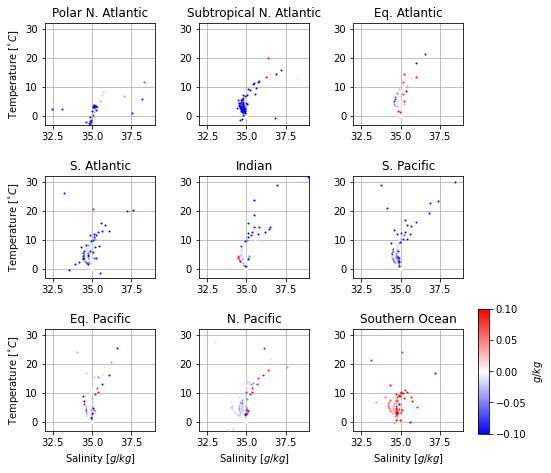

CPU times: user 20.9 s, sys: 999 ms, total: 21.9 s
Wall time: 22.3 s


In [28]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dS_adjustment[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
plt.show()

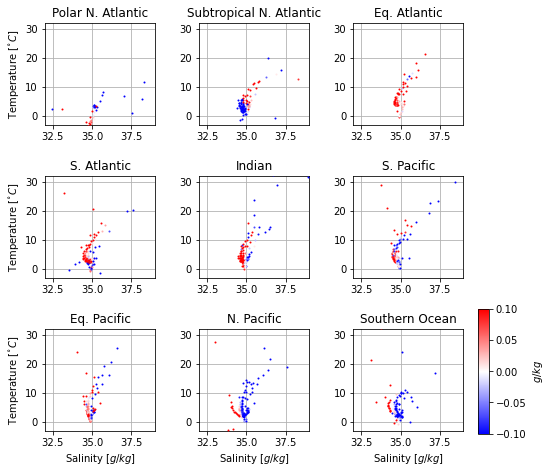

CPU times: user 18.5 s, sys: 785 ms, total: 19.3 s
Wall time: 19.2 s


In [29]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dS_mixing[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
plt.show()

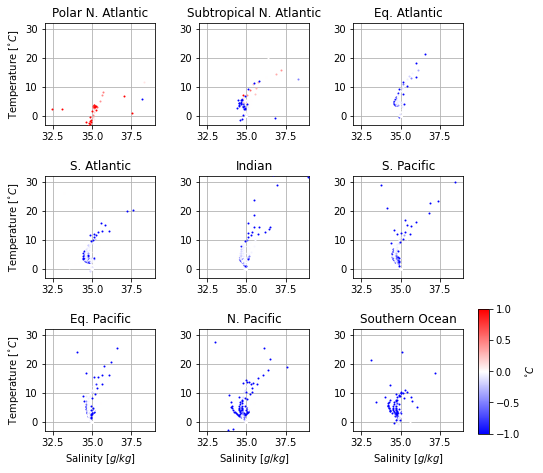

CPU times: user 21.8 s, sys: 1.04 s, total: 22.9 s
Wall time: 23.2 s


In [30]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -1,1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dT_adjustment[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
plt.show()

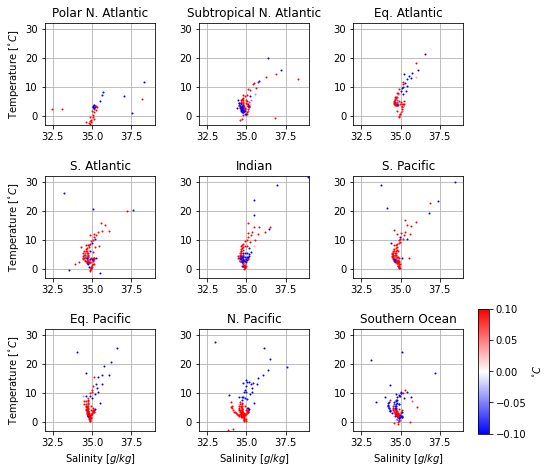

CPU times: user 21.9 s, sys: 1.08 s, total: 23 s
Wall time: 23.4 s


In [31]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dT_mixing[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
plt.show()

In [32]:
# fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=0.4)
# axs = axs.ravel() 

# k=0
# for i in range(np.array(Basins).size):
#     for j in range(SA_early.shape[1]):
#         col = 1-np.maximum(0.1,(np.log10(Vol_1[k]+1)-14)/(np.log10(np.max(Vol_1))-14))
#         axs[i].scatter(S_1[k]+S0,T_1[k],\
#                 s=50,\
#                 marker = 'o', facecolor='none', edgecolor='grey', label = 't2', zorder=-100)
#         axs[i].scatter(S_2[k]+S0,T_2[k],\
#                 s=50,\
#                 marker = 'v', facecolor='none', edgecolor='grey', label = 't1', zorder=-100)
#         if ~np.isnan(Opt_result.dT_mixing[k]) | ~np.isnan(Opt_result.dS_mixing[k]):
#                 ann1 = axs[i].annotate('', xy=(S_1[k]+S0, T_1[k]), xytext=(S_1[k]+Opt_result.dS_mixing[k]+S0, T_1[k]+Opt_result.dT_mixing[k]),
#     arrowprops=dict(arrowstyle="<-", color=[col,col,1]), annotation_clip=False)
#                 ann2 = axs[i].annotate('', xy=(S_1[k]+Opt_result.dS_mixing[k]+S0, T_1[k]+Opt_result.dT_mixing[k]), \
#                     xytext=(S_1[k]+Opt_result.dS_mixing[k]+S0+Opt_result.dS_adjustment[k], \
#                             T_1[k]+Opt_result.dT_mixing[k]+Opt_result.dT_adjustment[k]),
#     arrowprops=dict(arrowstyle="<-", color=[1,col,col]), annotation_clip=False)
#         else:
#                 ann1 = axs[i].annotate('', xy=(S_1[k]+S0, T_1[k]), \
#                     xytext=(S_1[k]+S0+Opt_result.dS_adjustment[k], T_1[k]+Opt_result.dT_adjustment[k]),
#     arrowprops=dict(arrowstyle="<-", color='red'), annotation_clip=False)
#         axs[i].set_xlim(30,40)
#         axs[i].set_ylim(-4,32)
#         axs[i].set_title(Basins[i])
#         ann1.arrow_patch.set_clip_box(axs[i].bbox)
#         ann2.arrow_patch.set_clip_box(axs[i].bbox)
#         k=k+1

# m = plt.cm.ScalarMappable(cmap='bwr')
# m.set_clim(minv, maxv)
# cbar = fig.colorbar(m, cax=cax, orientation='vertical')
# cbar.set_label('$^{\circ}C$')
# plt.savefig('Figures/Mixing_vectors.png', dpi=300, bbox_inches='tight')
# plt.show()